# Tensorflow 2

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, time
import cv2
import argparse, random
import skimage.transform
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import scipy.io

In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
print(tf.__version__)

2.3.1


In [4]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [5]:
# Configuration
IMG_SIZE = 112
EPOCHS = 20
BATCH_SIZE = 256

delta = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]
delta_i = delta[-1]

PATH = os.path.abspath('.') + "/dataset/PlacePulse"
IMG_PATH = PATH + "/images/2011/"
LABEL_PATH = PATH + "/labels/"

SAVE_PATH = 'saved_models/mod_models/'
if not os.path.exists(SAVE_PATH):
  os.makedirs(SAVE_PATH)

Train_model = True

num_test_sample = 50

units = 256 # any
embedding_dim = 512

input_shape = (IMG_SIZE,IMG_SIZE,1)
output_shape = 10

In [6]:
mat_data_train = scipy.io.loadmat('../dataset/MNIST_mod/MNIST_data_train_re.mat')
mat_data_test = scipy.io.loadmat('../dataset/MNIST_mod/MNIST_data_test_re.mat')

train_x = np.float32(mat_data_train['X_train'])
train_y = np.float32(mat_data_train['Y_train'])

test_x = np.float32(mat_data_test['X_test'])#[:9900, :]
test_y = np.float32(mat_data_test['Y_test'])#[:9900, :]

print(train_x.shape, train_y.shape)
train_x = np.expand_dims(train_x, axis=3)
test_x = np.expand_dims(test_x, axis=3)
print(train_x.shape, train_y.shape)

# validation_x = mat_data_test['X_test'][9900:, :]
# validation_y = mat_data_test['Y_test'][9900:, :]

del mat_data_train
del mat_data_test

print("Train data shape: " + str(train_x.shape))
print("Train label shape: " + str(train_y.shape))
print("Test data shape: " + str(test_x.shape))
print("Test label shape: " + str(test_y.shape))
# print("Validation data shape: " + str(validation_x.shape))
# print("Validation label shape: " + str(validation_y.shape))
print(np.max(test_x), np.min(test_x))

(55000, 112, 112) (55000, 10)
(55000, 112, 112, 1) (55000, 10)
Train data shape: (55000, 112, 112, 1)
Train label shape: (55000, 10)
Test data shape: (10000, 112, 112, 1)
Test label shape: (10000, 10)
1.0 0.0


In [7]:
from keras import backend as K

def get_outputs(seed_input, model, layer_name=None, layer_id=None):
    inp = model.input                                                      # input placeholder
    if not layer_name and not layer_id:
        outputs = {layer.name:layer.output for layer in model.layers[1:]}  # all layer outputs
        
    elif layer_name and not layer_id:
        layer = model_to_predict.get_layer(layer_name)
        outputs = {layer.name:layer.output}
        
    elif not layer_name and layer_id: # !=0
        layer = model.layers[layer_id]
        outputs = {layer.name:layer.output}
    
    functor = K.function([inp, K.learning_phase()], outputs )             # function to evaluate
    layer_outs = functor([seed_input[np.newaxis,...]])
    return layer_outs

In [8]:
def reset_state(batch_size, units):
  return tf.zeros((batch_size, units), tf.float32)
    
def loss_function(real, pred):
  #pred_ = tf.nn.softmax(pred)
  #loss_ = cost(real, pred_)
  cost = tf.nn.sigmoid_cross_entropy_with_logits(labels = real, logits = pred)
  return tf.reduce_mean(cost)

In [9]:
def plot_map(_img, grads, class_idx, y_pred, show_cam=True):
  fig, axes = plt.subplots(1,2,figsize=(14,5))
  axes[0].imshow(_img, cmap="gray")
  axes[1].imshow(_img, cmap="gray")
  i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
  fig.colorbar(i)
  plt.suptitle("Pr(class={}) = {:5.2f}".format(class_idx, y_pred[0,class_idx]))
  
  if show_cam:
    plt.show()
  else:
    plt.savefig("sample_cam.png", bbox_inches='tight', pad_inches = 0)

    plt.clf()
    plt.cla()
    plt.close()

In [10]:
class SoftAttentionLayer(tf.keras.layers.Layer):
  def __init__(self, units, name='AttentionLayer', **kwargs):
    self.units = units
    super(SoftAttentionLayer, self).__init__(name=name, **kwargs)

    #super(SoftAttentionLayer, self).__init__(**kwargs)
    #self.name = name
  def build(self, input_shape):
    self.W1 = tf.keras.layers.Dense(self.units, kernel_initializer=tf.initializers.GlorotUniform(), bias_initializer=tf.initializers.GlorotUniform())
    self.W2 = tf.keras.layers.Dense(self.units, kernel_initializer=tf.initializers.GlorotUniform(), bias_initializer=tf.initializers.GlorotUniform())
    self.V = tf.keras.layers.Dense(1, kernel_initializer=tf.initializers.GlorotUniform(), bias_initializer=tf.initializers.GlorotUniform())
    
  def call(self, features, hidden):

    # features(CNN_encoder output) shape == (batch_size, 196, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 196, hidden_size)
    #print("feature:", features.shape)
    #print("hidden:", hidden_with_time_axis.shape)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 196, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    #attention_weights = tf.reshape(attention_weights, (-1, ))

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    #print("weights", attention_weights.shape, "feat", features.shape, "context", context_vector.shape)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    #print("context:", context_vector.shape)

    return attention_weights, context_vector  #alpha, z

  def get_config(self):
    config = {'units': self.units,
             }
    base_config = super(SoftAttentionLayer, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [11]:
from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, LSTMCell, Reshape, Dense, GlobalAveragePooling2D, Activation

from keras.callbacks import ModelCheckpoint

checkpoint_file = SAVE_PATH + "best.h5"

In [12]:
if Train_model:

  input_image = Input(shape=input_shape, name='input_image')
  #states = Input(shape=(units))

  initializer = tf.initializers.GlorotUniform()

  x = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', name="conv_1", bias_initializer='glorot_uniform')(input_image)
  x = Activation('relu')(x)
  x = Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), padding='same', name="conv_2", bias_initializer='glorot_uniform')(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=embedding_dim, kernel_size=(3,3), strides=(2,2), padding='same', name="conv_3", bias_initializer='glorot_uniform')(x)
  x = Activation('relu')(x)
    
  x = Reshape((-1, embedding_dim))(x)
  
  hidden = reset_state(tf.shape(x)[0], units)
  memmory = reset_state(tf.shape(x)[0], units)

  alpha, z = SoftAttentionLayer(units, name="att_1")(x, hidden)
  lstm_input = Concatenate(axis=1)([z, hidden])
  _, [h, c] = LSTMCell(units)(lstm_input, [hidden, memmory])

  alpha, z = SoftAttentionLayer(units, name="att_2")(x, h)
  lstm_input = Concatenate(axis=1)([z, h])
  _, [h, c] = LSTMCell(units)(lstm_input, [h, c])

  alpha, z = SoftAttentionLayer(units, name="att_3")(x, h)
  lstm_input = Concatenate(axis=1)([z, h])
  _, [h, c] = LSTMCell(units)(lstm_input, [h, c])

  alpha, z = SoftAttentionLayer(units, name="att_4")(x, h)
  lstm_input = Concatenate(axis=1)([z, h])
  _, [h, c] = LSTMCell(units)(lstm_input, [h, c])

  y = Dense(output_shape, activation="linear", name="predictions", kernel_initializer=tf.initializers.GlorotUniform(), bias_initializer=tf.initializers.GlorotUniform())(h)

  att_model = Model(inputs=[input_image], outputs=[y])
  

  print("alpha:", alpha.shape,"z:", z.shape, "h:",hidden.shape, "c:", memmory.shape, "x:", x.shape, "lstm:", lstm_input.shape)

alpha: (None, 196, 1) z: (None, 512) h: (None, 256) c: (None, 256) x: (None, 196, 512) lstm: (None, 768)


In [13]:
if Train_model:
  att_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 112, 112, 1) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 56, 56, 64)   640         input_image[0][0]                
__________________________________________________________________________________________________
activation (Activation)         (None, 56, 56, 64)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 28, 28, 256)  147712      activation[0][0]                 
_______________________________________________________________________________________

In [14]:
if Train_model:
  tf.keras.utils.plot_model(att_model, show_shapes=True, to_file=SAVE_PATH+'att_model.png')

In [15]:
if Train_model:
  optm = tf.keras.optimizers.Adam(learning_rate=5e-4, epsilon=1e-8)
  #optimizer = tf.keras.optimizers.RMSprop()
  #loss_object = tf.keras.losses.MeanSquaredError()
  # loss_object = tf.keras.losses.CategoricalCrossentropy()
  checkpoints = ModelCheckpoint(checkpoint_file, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

  att_model.compile(optimizer=optm, loss=loss_function, metrics=['accuracy', 'mse'])

  train_h = np.zeros((train_x.shape[0], units))
  train_c = np.zeros((train_x.shape[0], units))
  print(train_x.shape, train_h.shape, train_c.shape)

  history = att_model.fit(train_x, train_y, batch_size= BATCH_SIZE, epochs= EPOCHS, validation_split=0.0, verbose=1, shuffle=True, callbacks = [checkpoints])

(55000, 112, 112, 1) (55000, 256) (55000, 256)
Train on 55000 samples
Epoch 1/20
55000/55000 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.1031 - mse: 5.3871
Epoch 00001: accuracy improved from -inf to 0.10315, saving model to saved_models/models/best.h5
55000/55000 [==============================] - 66s 1ms/sample - loss: 0.3349 - accuracy: 0.1031 - mse: 5.3871
Epoch 2/20
55000/55000 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.1865 - mse: 6.7450
Epoch 00002: accuracy improved from 0.10315 to 0.18647, saving model to saved_models/models/best.h5
55000/55000 [==============================] - 65s 1ms/sample - loss: 0.3059 - accuracy: 0.1865 - mse: 6.7450
Epoch 3/20
55000/55000 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.8750 - mse: 29.9953
Epoch 00003: accuracy improved from 0.18647 to 0.87498, saving model to saved_models/models/best.h5
55000/55000 [==============================] - 65s 1ms/sample - loss: 

In [16]:
from tensorflow.keras.models import load_model

if Train_model:
  model_to_predict = att_model
else:
  model_to_predict = load_model(checkpoint_file, custom_objects={'SoftAttentionLayer':SoftAttentionLayer, "loss_function":loss_function})

In [17]:
if not Train_model:
  model_to_predict.summary()

In [18]:
if not Train_model:
  tf.keras.utils.plot_model(model_to_predict, show_shapes=True, to_file=SAVE_PATH+'att_model.png')

In [19]:
evaluations = model_to_predict.evaluate(test_x, test_y, batch_size=BATCH_SIZE, verbose=1)
metric_loss = model_to_predict.metrics_names[0]
loss_value = evaluations[0]
metric_acc = model_to_predict.metrics_names[1]
acc_value = evaluations[1]
metric_mse = model_to_predict.metrics_names[2]
mse_value = evaluations[2]
print("%s: %.2f%%" % (metric_loss, loss_value*100))
print("%s: %.2f%%" % (metric_acc, acc_value*100))
print("%s: %.2f%%" % (metric_mse, mse_value*100))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
loss: 1.35%
accuracy: 98.16%
mse: 10647.83%


<ipython-input-20-5f24180b4953>:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3, figsize=(9,3))


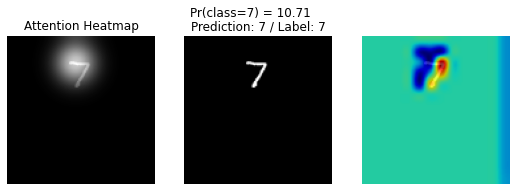

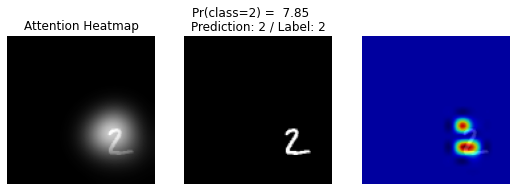

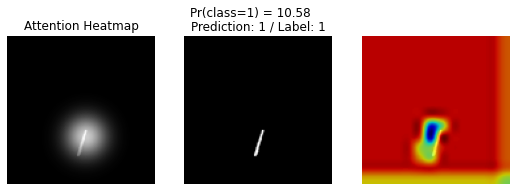

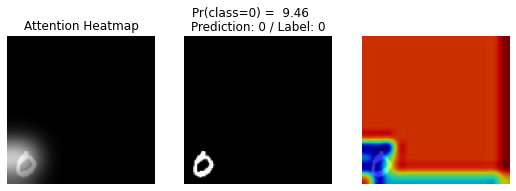

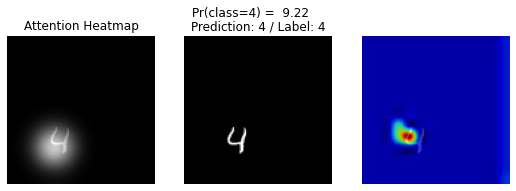

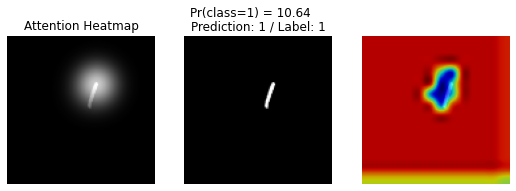

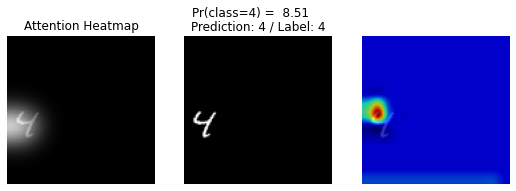

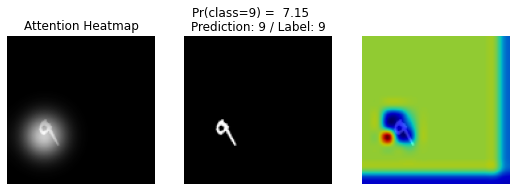

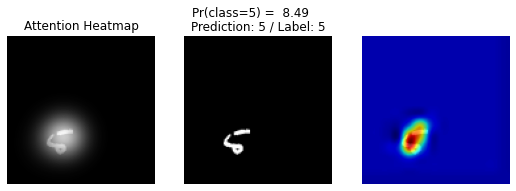

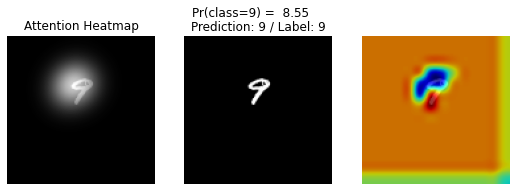

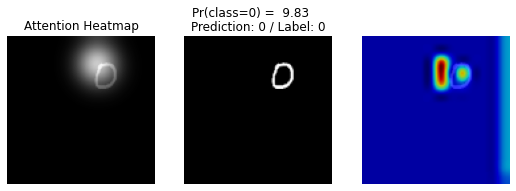

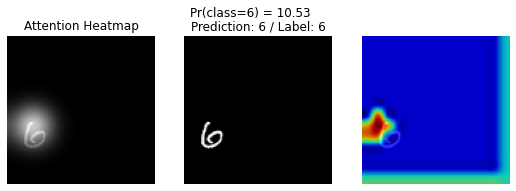

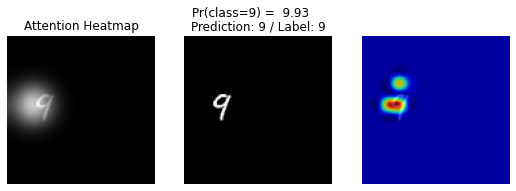

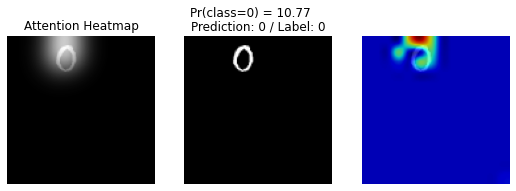

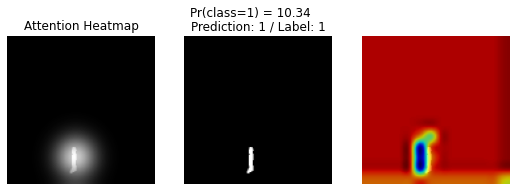

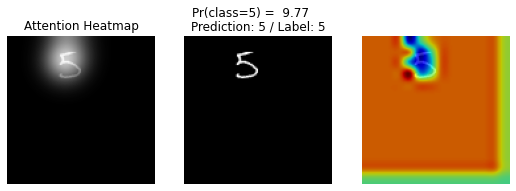

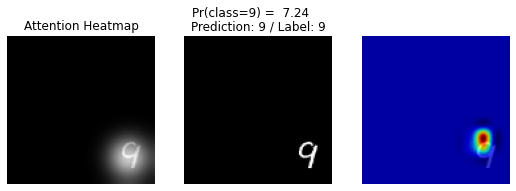

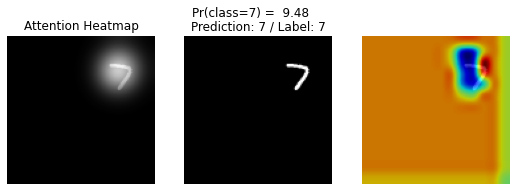

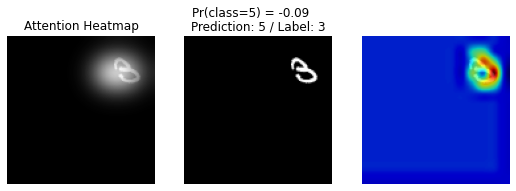

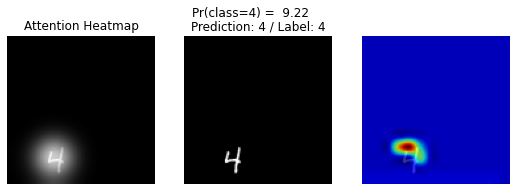

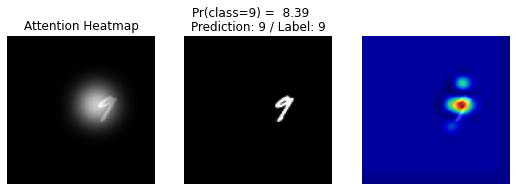

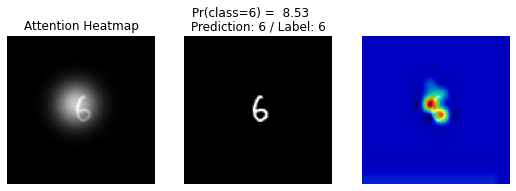

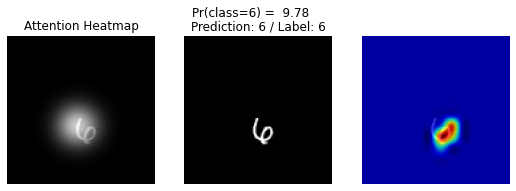

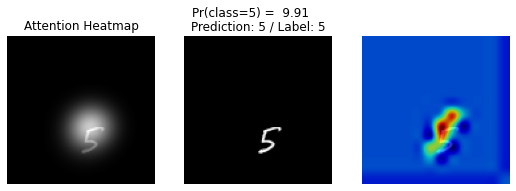

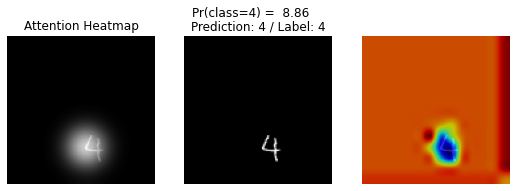

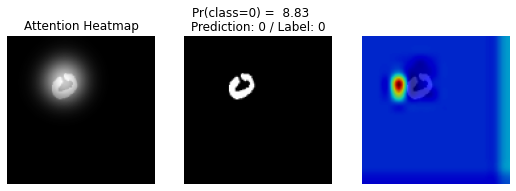

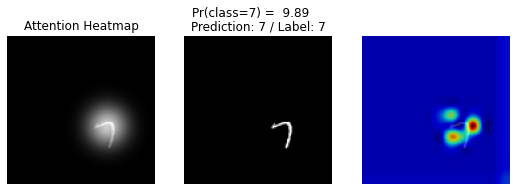

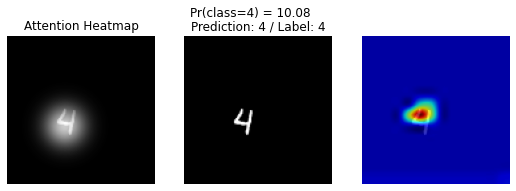

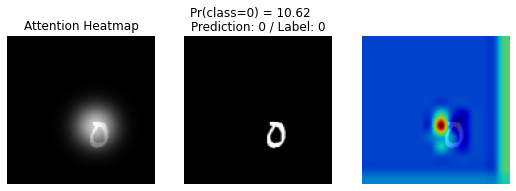

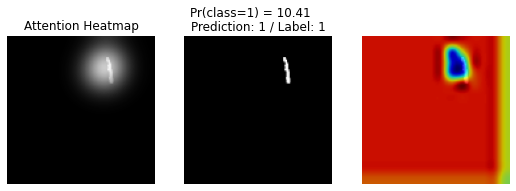

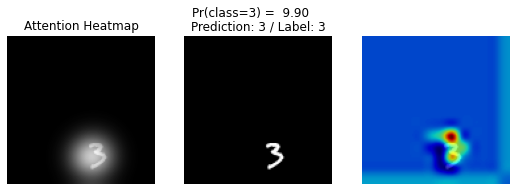

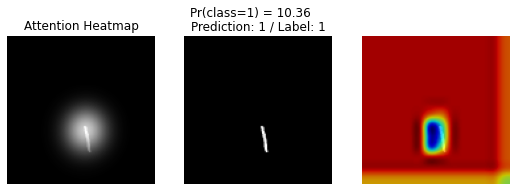

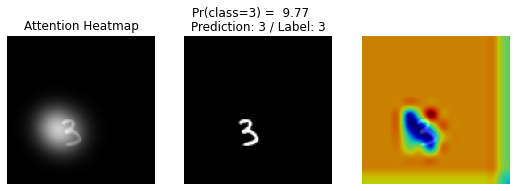

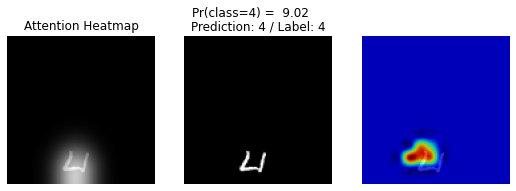

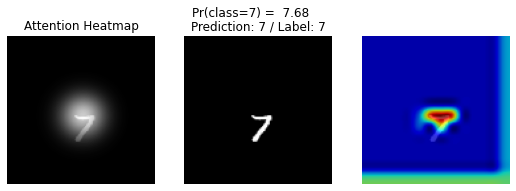

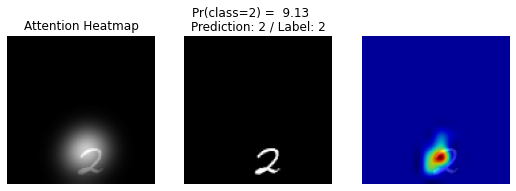

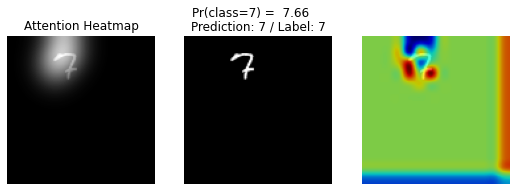

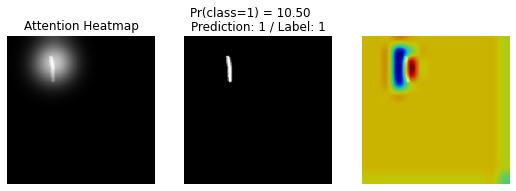

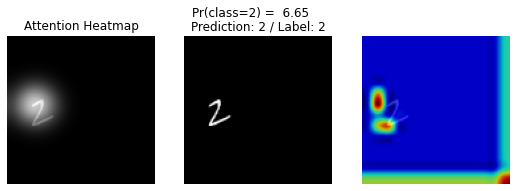

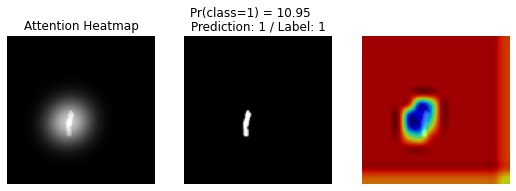

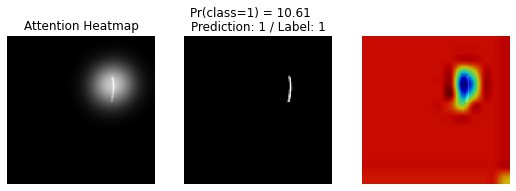

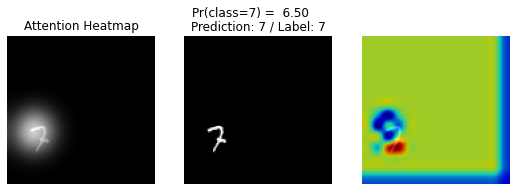

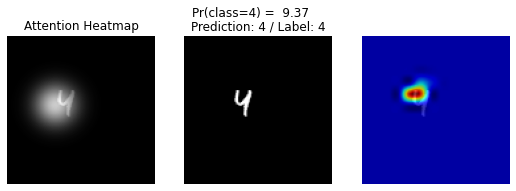

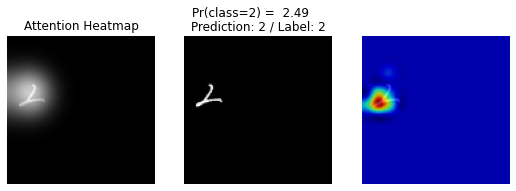

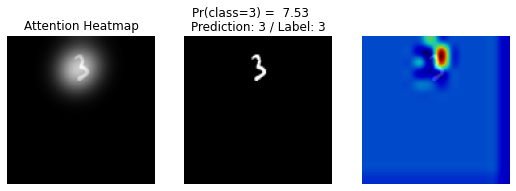

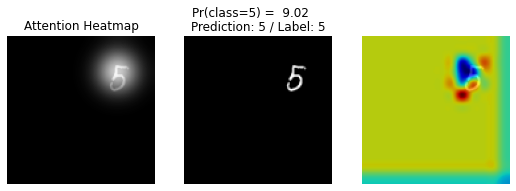

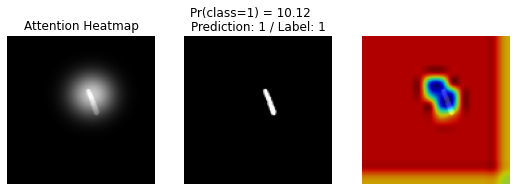

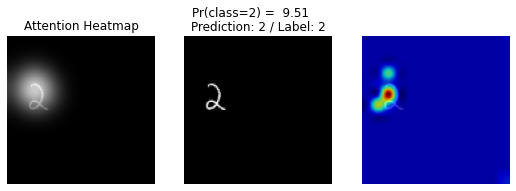

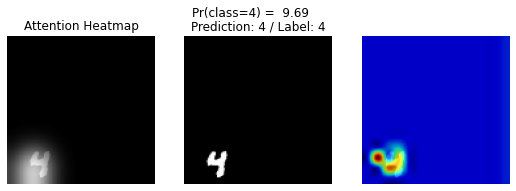

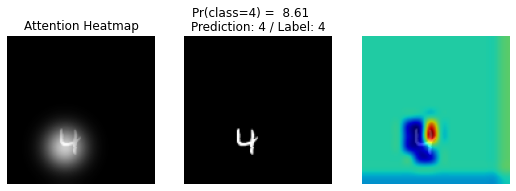

Sample Accuracy: 0.98


In [20]:
from vis.visualization import visualize_cam
from vis.utils import utils

layer_idx = utils.find_layer_idx(model_to_predict, 'predictions')
penultimate_layer_idx = utils.find_layer_idx(model_to_predict, "conv_3")
ultimate_attention_layer_idx = utils.find_layer_idx(model_to_predict, "att_4")

num_correct = 0.

# Test for Sampling data
for idx_sample in range(num_test_sample):
    seed_input = test_x[idx_sample]
    
    y_pred = model_to_predict.predict(seed_input[np.newaxis,...])
    class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
    class_idx = class_idxs_sorted[0]
    
    y_test_pred  = class_idxs_sorted[0]
    y_test_true = np.argmax(test_y[idx_sample, :])

    viscam_img = visualize_cam(model_to_predict,
                               layer_idx=layer_idx,
                               filter_indices=class_idx,
                               seed_input=seed_input,
                               penultimate_layer_idx = penultimate_layer_idx, 
                               backprop_modifier = None, grad_modifier = None)
    
    model_outputs = get_outputs(seed_input, model_to_predict,layer_id=ultimate_attention_layer_idx)

    attention_weights = model_outputs["att_4"][0]
    alpha_ = attention_weights[:,:,0]
    alpha_size = int(np.sqrt(alpha_.shape[1]))
    alpha_reshape = np.reshape(alpha_, (alpha_size, alpha_size))
    alpha_resize = skimage.transform.pyramid_expand(alpha_reshape, upscale = 16, sigma=20)
    alpha_resize = cv2.resize(alpha_resize, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

    # Draw subplot for each sample 
    fig, ax = plt.subplots(1,3, figsize=(9,3))
    ax[0].imshow(seed_input, cmap='gray')
    i = ax[0].imshow(alpha_resize,cmap="gray", alpha=0.8)
    ax[0].axis("off")
    ax[0].set_title('Attention Heatmap')
    
    ax[1].imshow(seed_input, cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Prediction: ' + str(y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))
    
    ax[2].imshow(seed_input, cmap="gray")
    i = ax[2].imshow(viscam_img,cmap="jet", alpha=0.8)
    ax[2].axis("off")
    #fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f}".format(class_idx, y_pred[0,class_idx]))

    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.
    
# Show results 
plt.show()
print('Sample Accuracy: ' + str(num_correct / num_test_sample))